In [1]:
# Example of maximum-likelihood fit with iminuit version 2.
# pdf is a mixture of Gaussian (signal) and exponential (background),
# truncated in [xMin,xMax].
# G. Cowan / RHUL Physics / December 2021

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from scipy.stats import chi2
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import container
plt.rcParams["font.size"] = 14
print("iminuit version:", iminuit.__version__)  # need 2.x

import mplhep
mplhep.style.use("ATLAS")

iminuit version: 2.24.0


In [2]:
# define pdf and generate data
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb
        
numVal = 10000
xData = np.empty([numVal])
for i in range (numVal):
    r = np.random.uniform()
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

# Function to be minimized is negative log-likelihood
def negLogL(par):
    pdf = f(xData, par)
    return -np.sum(np.log(pdf))

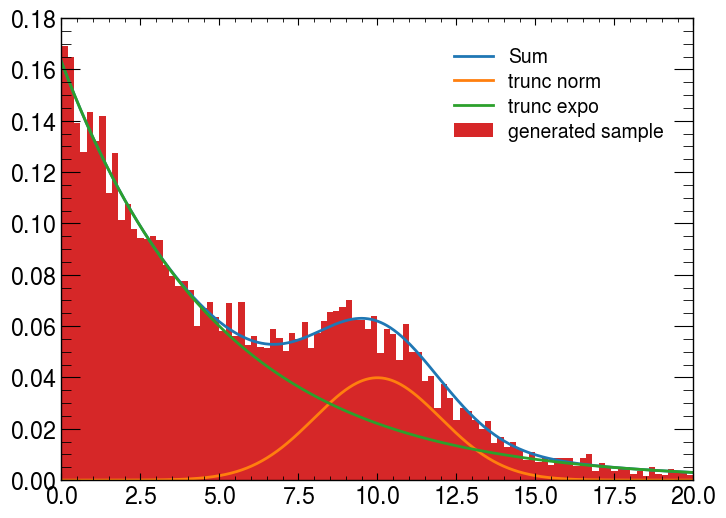

In [3]:
fig, ax = plt.subplots()
xs = np.linspace(0, 20, 1000)
par = (theta, mu, sigma, xi)
ax.plot(xs, f(xs, (par)), label="Sum")
ax.plot(xs, theta*stats.truncnorm.pdf(xs, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma), label="trunc norm")
ax.plot(xs, (1-theta)*stats.truncexpon.pdf(xs, b=(xMax-xMin)/xi, loc=xMin, scale=xi), label="trunc expo")
ax.hist(xData, bins=np.linspace(0,20,101), label="generated sample", density=True)
ax.legend()

In [4]:
# Initialize Minuit and set up fit:
parin   = np.array([theta, mu, sigma, xi]) # initial values (here = true values)
parname = ['theta', 'mu', 'sigma', 'xi']
parstep = np.array([0.1, 1., 1., 1.])      # initial setp sizes
parfix  = [False, True, True, False]       # change these to fix/free parameters
parlim  = [(0.,1), (None, None), (0., None), (0., None)]    # set limits
m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                           # errors from lnL = lnLmax - 0.5

In [5]:
# Do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.
    
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not(m.fixed[i]):
        for j in range(m.npar):
            if not(m.fixed[j]):
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 theta       =  0.192273  +/-  0.007361
   3 xi          =  4.966974  +/-  0.088109

free par indices, covariance, correlation coeff.:
0 0 0.000054 1.000000
0 3 -0.000354 -0.545386
3 0 -0.000354 -0.545386
3 3 0.007763 1.000000


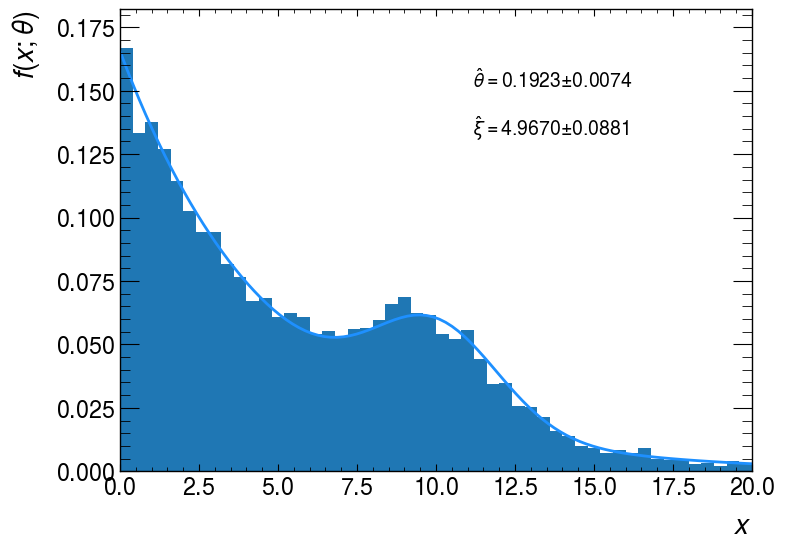

In [11]:
# Plot fitted pdf
yMin = 0.
yMax = f(0., MLE)*1.1
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, MLE)
plt.plot(xCurve, yCurve, color='dodgerblue')

# Plot data as tick marks
# tick_height = 0.05*(yMax - yMin)
# xvals = [xData, xData]
# yvals = [np.zeros_like(xData), tick_height * np.ones_like(xData)]
# plt.plot(xvals, yvals, color='black', linewidth=1)
plt.hist(xData, bins=np.linspace(0,20,51), density=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x; \theta)$')
plt.figtext(0.6, 0.8, r'$\hat{\theta} = $' + f'{MLE[0]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[0]:.4f}')
plt.figtext(0.6, 0.72, r'$\hat{\xi} = $' + f'{MLE[3]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[3]:.4f}')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.show()


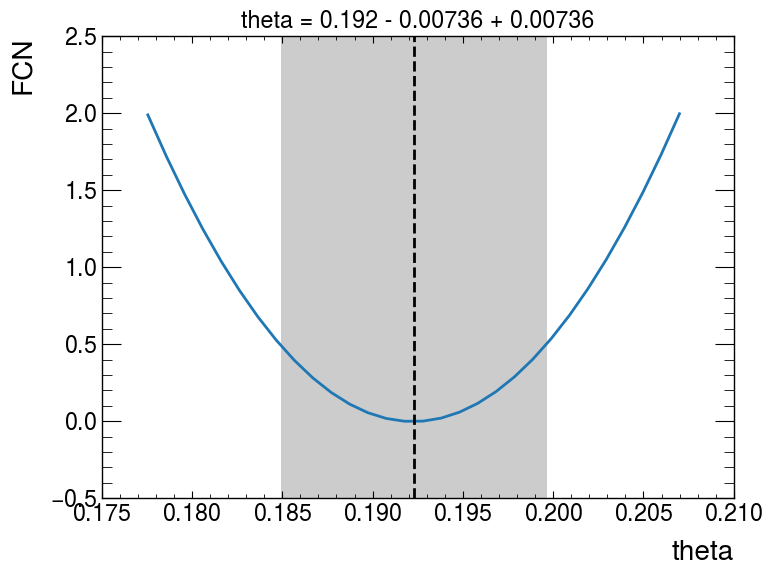

CL =  0.3934693402873665


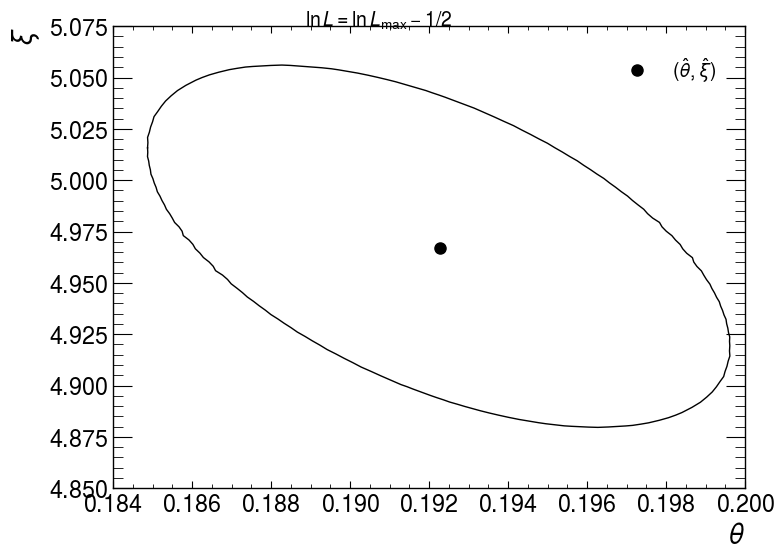

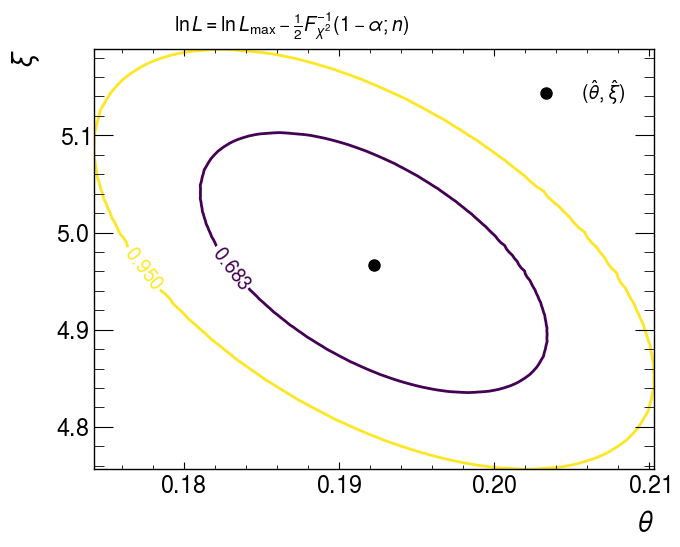

In [12]:

# Make scan of lnL (for theta, if free)
if not(m.fixed['theta']):
    plt.figure()
    m.draw_mnprofile('theta')
    plt.show()
    
# Make a contour plot of lnL = lnLmax - 1/2 (here for theta and xi).
# The tangents to this contour give the standard deviations.
CL = stats.chi2.cdf(1.,2)            #  Q_alpha = 1, npar = 2
print('CL = ', CL)
if not(m.fixed['theta'] | m.fixed['xi']):
    fig, ax = plt.subplots(1,1)
    con = m.mncontour('theta', 'xi', cl=CL, size=200)
    con = np.vstack([con, con[0]])         # close contour
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.plot(con[:,0], con[:,1], color='black', linewidth=1)
    plt.xlabel(r'$\theta$', labelpad=5)
    plt.ylabel(r'$\xi$', labelpad=5)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.4, 0.93, r'$\ln L = \ln L_{\rm max} - 1/2$')
    plt.show()

# Confidence region from lnL = lnLmax - Q/2 (here for theta and xi)
# where Q is the chi2 quantile of CL = 1-alpha = 0.683 and 0.95 for 2 dof.
if not(m.fixed['theta'] | m.fixed['xi']):
    fig, ax = plt.subplots(1,1)
    m.draw_mncontour('theta', 'xi', cl=[0.683, 0.95], size=200)
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.xlabel(r'$\theta$', labelpad=10)
    plt.ylabel(r'$\xi$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.3, 0.93, r'$\ln L = \ln L_{\rm max} - \frac{1}{2} F^{-1}_{\chi^2}(1-\alpha;n)$')
    plt.show()